In [3]:

import sys
import os
module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append('/Users/lex/miniconda2/lib/python2.7/site-packages')
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import keras.preprocessing.sequence as pre
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,TimeDistributed,Flatten,Masking
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import util.util as util
import pandas_datareader.data as web

In [4]:
import stockstats

In [5]:
from stockstats import StockDataFrame

def set_up_df(csv):
    df = pd.read_csv(csv)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'ticker', 'date']]
    df['date'] = pd.to_datetime(df['date'])
    df.index = df['date']
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'ticker']]
    return df

def find_stock_features(df):
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.price_change = (df.Close / df.Close.shift(1)) - 1
    new = stockstats.StockDataFrame.retype(df)
    new.get('macd')
    new.get('cci')
    new.get('rsi_6')
    new.get('dma')
    new.get('adx')
    new.get('trix')
    new.get('atr')
    return new

def normalize_data(df, columns):
    min_max_scaler = MinMaxScaler()
    df[columns] = min_max_scaler.fit_transform(df[columns].as_matrix())
    return df, min_max_scaler
  
def create_stock_data(ticker, df):
    df_stock = df.iloc[df.index.get_level_values('Symbol') == ticker]
    df_stock = df_stock[['Open', 'High', 'Low', 'Close', 'Volume']]
    df_stock = find_stock_features(df_stock)
    df_stock = df_stock.dropna()
    diff_df = df_stock.diff().dropna()
    last_date = diff_df.index[0]
    diff_df = diff_df.reset_index(drop=True)

    diff_df = diff_df[[u'open', u'high', u'low',
                       u'close', u'volume', u'close_26_ema', u'macd',
                       u'macds', u'macdh', u'middle', u'middle_14_sma',
                       u'cci', u'close_-1_s', u'close_-1_d', u'rs_6',
                       u'rsi_6', u'close_10_sma', u'close_50_sma', u'dma',
                       u'high_delta', u'um', u'low_delta', u'dm',
                       u'pdm', u'pdm_14_ema', u'pdm_14', u'tr',
                       u'atr_14', u'pdi_14', u'pdi', u'mdm',
                       u'mdm_14_ema', u'mdm_14', u'mdi_14', u'mdi',
                       u'dx_14', u'dx', u'dx_6_ema', u'adx',
                       u'adx_6_ema', u'adxr', u'trix', u'atr']]

    diff_df_matrix = clean_dataset(diff_df).as_matrix()

    return df_stock, diff_df_matrix, last_date

In [6]:
def create_multi_diff(df_in, intervals):
    df_diff = df_in.copy()
    for interval in intervals:
        if interval > 0:
            df_diff = df_diff.diff(periods=interval, axis=0)[interval:]
    return df_diff

def inverse_multi_diff(df_diff, intervals, df_init):
    assert (sum(intervals) == len(df_init.index))
    df_next_init = df_init[:sum(intervals)]
    next_diff = []
    prev_diff = create_multi_diff(df_next_init, intervals[:-1]) if len(intervals) > 1 else df_init.copy()
    for i in range(intervals[-1] * 2):
        if i < intervals[-1]:
            next_diff.append(df_diff.values[i] + prev_diff.values[i])
        else:
            next_diff.append(df_diff.values[i - intervals[-1]] + prev_diff.values[i - intervals[-1]] + df_diff.values[i])
    next_diff = np.squeeze(next_diff).tolist()
    for i in range(len(df_diff.index) - len(next_diff)):
        next_diff.append(next_diff[i] + df_diff.values[i + intervals[-1]] + df_diff.values[i + intervals[-1] * 2])

    df_next_diff = pd.DataFrame(np.squeeze(next_diff), index=df_diff.index, columns=df_diff.columns)
    if len(intervals) > 1:
        df_next_diff = inverse_multi_diff(df_next_diff, intervals[:-1], df_init[intervals[-1]:])
    return df_next_diff

In [7]:
def difference_df(df, columns, length):
    for i in columns:
        new_series = df[i]
        df[i] = difference(new_series, length)
    return df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_series(old_series, transformed):
    values = []
    last_value = 0
    for i in range(len(transformed)):
        if i <= len(old_series)-1:
            new_value = old_series[i] + transformed[i]
            values.append(new_value)
            last_value = new_value
        else:
            new_value = last_value + transformed[i]
            last_value = new_value
            values.append(last_value)
    return pd.Series(values)

def inverse_df(old_df, new_df, columns):
    new_data = pd.DataFrame(columns=columns)
    for i in columns:
        old = old_df[i]
        new = new_df[i]
        
        inversed_data = inverse_series(old, new)
        
        new_data[i] = inversed_data
    return new_data
  

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


In [8]:
def create_datasets(diff_df_matrix, last_date):
  data_raw_x = diff_df_matrix
  data_raw_y = diff_df_matrix[:,[1,2,3,4,5]]# convert to numpy array

  min_max_scaler_x = StandardScaler()
  x_norm = min_max_scaler_x.fit_transform(data_raw_x)
  print x_norm.shape

  x_norm = util.add_date_features(last_date[1], x_norm)

  min_max_scaler_y = MinMaxScaler()
  y_norm = min_max_scaler_y.fit_transform(data_raw_y)

  index_range_x = 90 + 90

  data = []
  data_y = []


    # create all possible sequences of length seq_len
  for index in range(len(x_norm) - index_range_x):
    data.append(x_norm[index: index + 90])

  for index in range(90, len(y_norm) - 90):
    data_y_array = y_norm[index: index + 90]
    data_y.append(data_y_array)

  data = np.array(data);
  data_y = np.array(data_y);
  valid_set_size = int(np.round(np.float(util.valid_set_size_percentage) / 100 * data.shape[0]));
  test_set_size = int(np.round(np.float(util.test_set_size_percentage) / 100 * data.shape[0]));
  train_set_size = data.shape[0] - (valid_set_size + test_set_size);

  x_train = data[:train_set_size, :-1, :]
  y_train = data_y[:train_set_size, :-1, :]

  x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
  y_valid = data_y[train_set_size:train_set_size + valid_set_size, :-1, :]

  x_test = data[train_set_size + valid_set_size:, :-1, :]
  y_test = data_y[train_set_size + valid_set_size:, :-1, :]
  return x_train, y_train, x_valid, y_valid, x_test, y_test, min_max_scaler_x, min_max_scaler_y

In [9]:
stock_list = ['PFE', 'HPE', 'NOK', 'SNAP', 'FB'] #, 'PFE', 'HPE', 'NOK', 'SNAP', 'FB', 'NVDA', 'MSFT',
             #'ORCL', 'BABA', 'XOM', 'TWTR', 'X', 'DIS', 'KO', 'DAL', 'S', 'KR', 'JNJ', 'HAL', 
             #'PG', 'M', 'WMT', 'NKE', 'APRN', 'LOW', 'AMZN', 'AAPL', 'GOOGL', 'AMD', 'TSLA',
             #'ADP', 'CSCO', 'DVMT', 'GRMN', 'IBM', 'LOGI', 'VOD', 'VZ']

In [10]:
stock_data = pd.DataFrame()
for x in stock_list:
  print x
  df = web.DataReader(x, 'morningstar', pd.datetime(2013,4,13), pd.datetime(2018,4,13))
  stock_data = stock_data.append(df)

PFE
HPE
NOK
SNAP
FB


In [11]:
stock_data.head()

Close   High      Low   Open    Volume
Symbol Date                                              
PFE    2013-04-15  30.45  30.99  30.4500  30.61  46919512
       2013-04-16  30.94  30.99  30.4800  30.54  31463344
       2013-04-17  30.87  30.94  30.5250  30.80  32245371
       2013-04-18  30.59  30.94  30.4800  30.85  31788406
       2013-04-19  31.06  31.06  30.6049  30.73  29233931

In [9]:
df_stock, diff_df_matrix, last_date = create_stock_data('GE', stock_data)

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/envs/py2env/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
df_stock.columns

Index([         u'open',          u'high',           u'low',         u'close',
              u'volume',  u'close_26_ema',          u'macd',         u'macds',
               u'macdh',        u'middle', u'middle_14_sma',           u'cci',
          u'close_-1_s',    u'close_-1_d',          u'rs_6',         u'rsi_6',
        u'close_10_sma',  u'close_50_sma',           u'dma',    u'high_delta',
                  u'um',     u'low_delta',            u'dm',           u'pdm',
          u'pdm_14_ema',        u'pdm_14',            u'tr',        u'atr_14',
              u'pdi_14',           u'pdi',           u'mdm',    u'mdm_14_ema',
              u'mdm_14',        u'mdi_14',           u'mdi',         u'dx_14',
                  u'dx',      u'dx_6_ema',           u'adx',     u'adx_6_ema',
                u'adxr',          u'trix',           u'atr'],
      dtype='object')

In [11]:
last_date[1]

Timestamp('2013-04-18 00:00:00')

In [12]:
data_raw_x = diff_df_matrix
data_raw_y = diff_df_matrix[:,[1,2,3,4,5]]# convert to numpy array

min_max_scaler_x = StandardScaler()
x_norm = min_max_scaler_x.fit_transform(data_raw_x)
print x_norm.shape

x_norm = util.add_date_features(last_date[1], x_norm)

min_max_scaler_y = MinMaxScaler()
y_norm = min_max_scaler_y.fit_transform(data_raw_y)

index_range_x = 90 + 90

data = []
data_y = []


    # create all possible sequences of length seq_len
for index in range(len(x_norm) - index_range_x):
    data.append(x_norm[index: index + 90])

for index in range(90, len(y_norm) - 90):
    data_y_array = y_norm[index: index + 90]
    data_y.append(data_y_array)

data = np.array(data);
data_y = np.array(data_y);
valid_set_size = int(np.round(np.float(util.valid_set_size_percentage) / 100 * data.shape[0]));
test_set_size = int(np.round(np.float(util.test_set_size_percentage) / 100 * data.shape[0]));
train_set_size = data.shape[0] - (valid_set_size + test_set_size);

x_train = data[:train_set_size, :-1, :]
y_train = data_y[:train_set_size, :-1, :]

x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
y_valid = data_y[train_set_size:train_set_size + valid_set_size, :-1, :]

x_test = data[train_set_size + valid_set_size:, :-1, :]
y_test = data_y[train_set_size + valid_set_size:, :-1, :]

(1302, 43)


In [13]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(89,124)))
model.add(LSTM(256,input_shape=(89,124),activation='tanh',return_sequences=True))
model.add(Dropout(0.10))
model.add(LSTM(145, activation='tanh', return_sequences=True))
model.add(Dropout(0.10))
model.add(LSTM(95, activation='tanh', return_sequences=True))
model.add(Dropout(0.10))
#model.add(Flatten())
model.add(Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',loss='mse')
history = model.fit(x_train, y_train, epochs=1,validation_data=(x_valid,y_valid),shuffle=False)

Train on 898 samples, validate on 112 samples
Epoch 1/1
898/898 [==============================] - 44s 49ms/step - loss: 0.0066 - val_loss: 0.0057


In [15]:
model.save('%s.h5' % last_date[0])

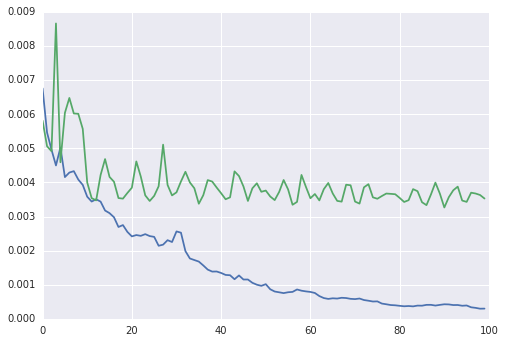

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [38]:
all_x = np.concatenate([x_train, x_test, x_valid])

In [39]:
all_y = np.concatenate([y_train, y_test, y_valid])

In [40]:
Xt = model.predict(all_x)

In [41]:
xt_0 = pd.DataFrame(Xt[0])
xt_0.index = xt_0.index+90
y_test_df = pd.DataFrame(all_y[0])
y_test_df.index = y_test_df.index+90
x_test_df = pd.DataFrame(all_x[0])

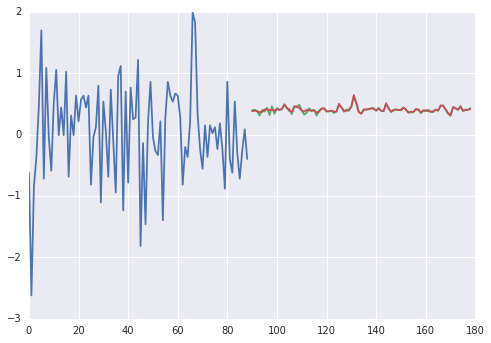

In [42]:
plt.plot(x_test_df[0])
plt.plot(y_test_df[0])
plt.plot(xt_0[0])

In [43]:
all_x.shape

(1122, 89, 124)

In [44]:
new_x = np.reshape(all_x[1], (89, 124))
for i in range(2, all_x.shape[0]/90+1):
    next_x = np.reshape(all_x[i*90], (89, 124))
    new_x = np.concatenate([new_x,next_x])

In [45]:
def inverse_x(x_matrix, min_max_scaler_x, begin_df):
    new_x = np.reshape(x_matrix[1], (89, 124))
    for i in range(2, x_matrix.shape[0]/90+1):
        next_x = np.reshape(x_matrix[i*90], (89, 124))
        new_x = np.concatenate([new_x,next_x])
    reverse_scale = min_max_scaler_x.inverse_transform(new_x[:,1:44])
    reverse_x_df = pd.DataFrame(reverse_scale)
    reverse_x_df.columns=begin_df.columns
    inverse_df_x = inverse_df(begin_df, reverse_x_df, reverse_x_df.columns)
    return inverse_df_x

In [46]:
reverse_scale = min_max_scaler_x.inverse_transform(new_x[:,1:44])

In [47]:
reverse_x_df = pd.DataFrame(reverse_scale)

In [49]:
reverse_x_df.columns=[u'open',          u'high',           u'low',
               u'close',        u'volume',  u'close_26_ema',          u'macd',
               u'macds',         u'macdh',        u'middle', u'middle_14_sma',
                 u'cci',    u'close_-1_s',    u'close_-1_d',          u'rs_6',
               u'rsi_6',  u'close_10_sma',  u'close_50_sma',           u'dma',
          u'high_delta',            u'um',     u'low_delta',            u'dm',
                 u'pdm',    u'pdm_14_ema',        u'pdm_14',            u'tr',
              u'atr_14',        u'pdi_14',           u'pdi',           u'mdm',
          u'mdm_14_ema',        u'mdm_14',        u'mdi_14',           u'mdi',
               u'dx_14',            u'dx',      u'dx_6_ema',           u'adx',
           u'adx_6_ema',          u'adxr',          u'trix',           u'atr']

In [52]:
inverse_df_x = inverse_df(df_stock, reverse_x_df, reverse_x_df.columns)

In [53]:
def inverse_y(y_matrix, min_max_scaler_y, input_predict):
    new_y = np.reshape(y_matrix[1], (89, 4))
    for i in range(2, y_matrix.shape[0]/90+1):
        next_y = np.reshape(y_matrix[i*90], (89, 4))
        new_y = np.concatenate([new_y,next_y])
    reverse_scale_y = min_max_scaler_y.inverse_transform(new_y)
    reverse_y_df = pd.DataFrame(reverse_scale_y)
    reverse_y_df.columns=['open', 'high', 'low', 'close']
    inverse_df_y = inverse_df(input_predict[90:90], reverse_y_df, ['open', 'high', 'low', 'close'])
    return

In [54]:
Xt.shape

(1122, 89, 5)

In [55]:
new_y = np.reshape(Xt[1], (89, 5))
for i in range(2, all_y.shape[0]/90+1):
    next_y = np.reshape(Xt[i*90], (89, 5))
    new_y = np.concatenate([new_y,next_y])
reverse_scale_y = min_max_scaler_y.inverse_transform(new_y)
reverse_y_df = pd.DataFrame(reverse_scale_y)
reverse_y_df.columns=['open', 'high', 'low', 'close', 'volume']
inverse_df_y = inverse_df(df_stock[90:90], reverse_y_df, ['open', 'high', 'low', 'close', 'volume'])

In [56]:
len(inverse_df_y)

1068

In [57]:
old_y = np.reshape(all_y[1], (89, 5))
for i in range(2, all_y.shape[0]/90+1):
    next_y = np.reshape(all_y[i*90], (89, 5))
    old_y = np.concatenate([new_y,next_y])
reverse_scale_y_old = min_max_scaler_y.inverse_transform(old_y)
reverse_y_df_old = pd.DataFrame(reverse_scale_y_old)
reverse_y_df_old.columns=['open', 'high', 'low', 'close', 'volume']
inverse_df_y_old = inverse_df(df_stock[90:90], reverse_y_df_old, ['open', 'high', 'low', 'close', 'volume'])

In [58]:
np.average(reverse_y_df_old.open)

0.0112291031823451

In [59]:
np.average(reverse_y_df.open)

0.017075907

In [60]:
len(inverse_df_y_old)

1157

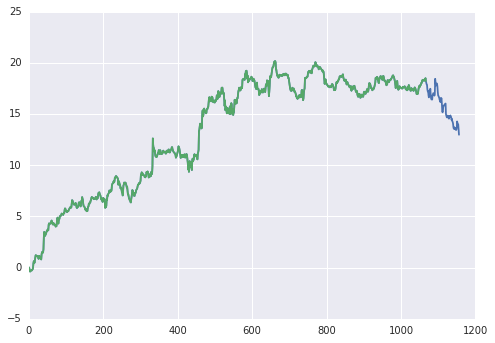

In [61]:
plt.plot(inverse_df_y_old.open)
plt.plot(inverse_df_y.open)

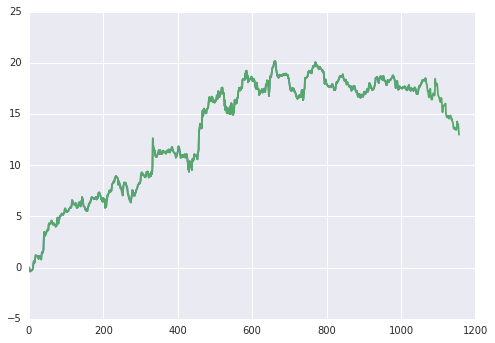

In [62]:
plt.plot(inverse_df_y.open)
plt.plot(inverse_df_y_old.open)

In [63]:
len(df_stock)

1303

In [89]:
last_predict = df_stock[(len(df_stock)-1)-89:len(df_stock)]

In [90]:
last_predict.index = last_predict.index.droplevel(0)

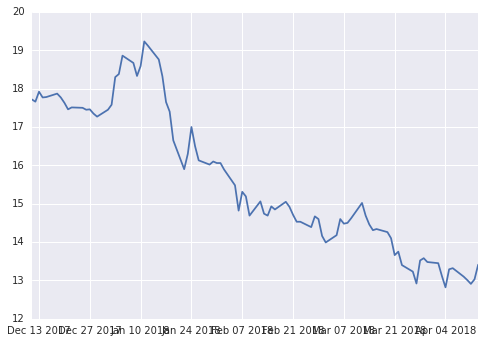

In [91]:
plt.plot(last_predict['open'])

In [92]:
last_predict_diff = last_predict.diff().dropna()

In [93]:
last_predict_matrix = last_predict_diff.as_matrix()

In [94]:
last_predict_norm = min_max_scaler_x.transform(last_predict_matrix)

In [95]:
x_norm = np.reshape(util.add_date_features(last_predict_diff.index[0], last_predict_norm), (1, 89, 124))

In [96]:
x_norm.shape

(1, 89, 124)

In [97]:
last_predict_y = np.reshape(model.predict(x_norm), (89,5))

In [98]:
reverse_scale_predict = min_max_scaler_y.inverse_transform(last_predict_y)
reverse_predict = pd.DataFrame(reverse_scale_predict)
reverse_predict.columns=['open', 'high', 'low', 'close','volume']
inverse_df_predict = inverse_df(last_predict[89:90], reverse_predict, ['open', 'high', 'low', 'close','volume'])

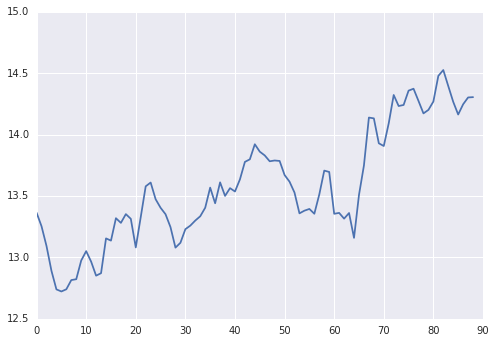

In [99]:
plt.plot(inverse_df_predict['open'])

In [100]:
inverse_df_predict.index = pd.date_range(start=pd.datetime(2018, 4, 13), end=pd.datetime(2018,7,10))

In [655]:
pd.datetime(2018,4,13) + datetime.timedelta(days=90)

datetime.datetime(2018, 7, 12, 0, 0)

In [101]:
df_stock.index = df_stock.index.droplevel(0)

In [102]:
add_prediction = inverse_df_predict.append(df_stock[['open', 'high', 'low', 'close', 'volume']])

In [103]:
add_prediction = add_prediction.sort_index()

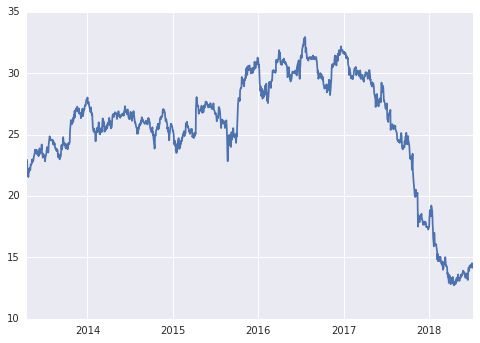

In [104]:
#last_predict = last_predict.reset_index(drop=True)
#df_stock = df_stock.reset_index(drop=True)
#inverse_df_predict.index = inverse_df_predict.index - len(df_stock)
#plt.plot(last_predict['open'])
plt.plot(add_prediction['open'])
#plt.plot(inverse_df_predict['open'])

In [105]:
add_prediction.to_csv('ge_prediction.csv')

In [129]:
new_predict = add_prediction[-95:-1]

In [131]:
new_predict.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [134]:
new_predict = find_stock_features(new_predict)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [135]:
new_predict.head()

,open,high,low,close,volume,close_26_ema,macd,macds,macdh,middle,...,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,atr
2018-04-06,13.32,13.4700,12.93,13.06,63465872.0,13.060000,0.000000,0.000000,0.000000,13.153333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-09,13.10,13.1600,12.82,12.83,68332636.0,12.940577,-0.005160,-0.002867,-0.004587,12.936667,...,17.331933,17.331933,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,-0.279886,0.340000
2018-04-10,13.01,13.1400,12.95,13.05,57656791.0,12.979892,0.000247,-0.001591,0.003675,13.046667,...,11.224620,11.224620,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,-0.107172,0.324444
2018-04-11,12.91,13.0799,12.85,12.97,50220026.0,12.977126,-0.000188,-0.001116,0.001855,12.966633,...,19.227648,19.227648,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,-0.061136,0.290567
2018-04-12,13.03,13.2450,12.97,13.18,63631230.0,13.024174,0.007936,0.001577,0.012718,13.131667,...,14.426391,14.426391,2.111313,2.111313,62.189392,62.189392,85.395227,85.395227,-0.008884,0.286233


In [136]:
new_predict = new_predict.dropna()
new_predict = new_predict.diff().dropna()
new_predict = new_predict.reset_index(drop=True)
new_predict = new_predict[[u'open',          u'high',           u'low',
               u'close',        u'volume',  u'close_26_ema',          u'macd',
               u'macds',         u'macdh',        u'middle', u'middle_14_sma',
                 u'cci',    u'close_-1_s',    u'close_-1_d',          u'rs_6',
               u'rsi_6',  u'close_10_sma',  u'close_50_sma',           u'dma',
          u'high_delta',            u'um',     u'low_delta',            u'dm',
                 u'pdm',    u'pdm_14_ema',        u'pdm_14',            u'tr',
              u'atr_14',        u'pdi_14',           u'pdi',           u'mdm',
          u'mdm_14_ema',        u'mdm_14',        u'mdi_14',           u'mdi',
               u'dx_14',            u'dx',      u'dx_6_ema',           u'adx',
           u'adx_6_ema',          u'adxr',          u'trix',           u'atr']]
new_predict_matrix = clean_dataset(new_predict).as_matrix()

In [137]:
new_predict_matrix = new_predict_matrix[2:91,:]

In [138]:
new_predict_norm = min_max_scaler_x.transform(new_predict_matrix)

In [139]:
new_predict_norm.shape

(89, 43)

In [140]:
new_predict_norm = np.reshape(util.add_date_features(pd.datetime(2018,4,12), new_predict_norm), (1,89,124))

In [141]:
new_predict_y = np.reshape(model.predict(new_predict_norm), (89,5))

In [142]:
new_predict_y = min_max_scaler_y.inverse_transform(new_predict_y)
reverse_predict_y = pd.DataFrame(new_predict_y)
reverse_predict_y.columns=['open', 'high', 'low', 'close','volume']
inverse_df_predict_y = inverse_df(add_prediction[-2:-1], reverse_predict_y, ['open', 'high', 'low', 'close','volume'])

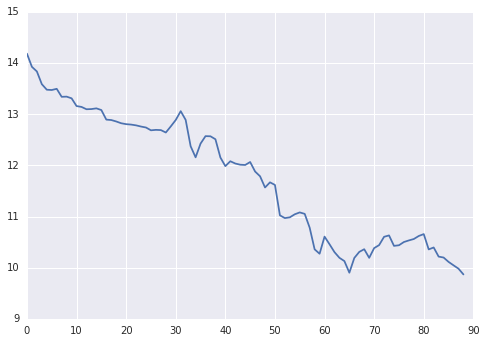

In [143]:
plt.plot(inverse_df_predict_y.open)

In [144]:
inverse_df_predict_y.index = pd.date_range(start=pd.datetime(2018, 7, 10), end=pd.datetime(2019,10,2))

In [145]:
add_prediction = add_prediction.append(inverse_df_predict_y).sort_index()

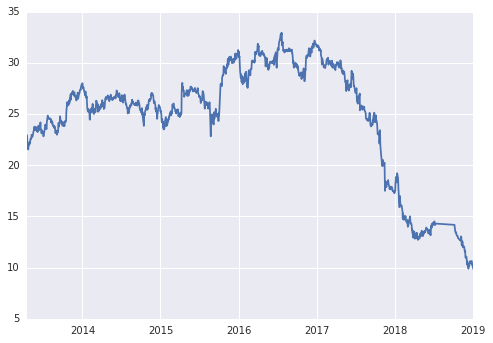

In [146]:
plt.plot(add_prediction.open)

In [12]:
for ticker in stock_list:
  print ticker
  df_stock, diff_df_matrix, last_date = create_stock_data(ticker, stock_data)
  x_train, y_train, x_valid, y_valid, x_test, y_test, min_max_scaler_x, min_max_scaler_y = create_datasets(diff_df_matrix, last_date)
  model = Sequential()
  model.add(Masking(mask_value=0.0, input_shape=(89,124)))
  model.add(LSTM(256,input_shape=(89,124),activation='tanh',return_sequences=True))
  model.add(Dropout(0.10))
  model.add(LSTM(145, activation='tanh', return_sequences=True))
  model.add(Dropout(0.10))
  model.add(LSTM(95, activation='tanh', return_sequences=True))
  model.add(Dropout(0.10))
  #model.add(Flatten())
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer='adam',loss='mse')
  history = model.fit(x_train, y_train, epochs=100,validation_data=(x_valid,y_valid),shuffle=False)
  model.save('%s_model.h5' % ticker)
  
  last_predict = df_stock[(len(df_stock)-1)-89:len(df_stock)]
  last_predict.index = last_predict.index.droplevel(0)
  last_predict_diff = last_predict.diff().dropna()
  
  last_predict_matrix = last_predict_diff.as_matrix()
  last_predict_norm = min_max_scaler_x.transform(last_predict_matrix)
  x_norm = np.reshape(util.add_date_features(last_predict_diff.index[0], last_predict_norm), (1, 89, 124))
  
  last_predict_y = np.reshape(model.predict(x_norm), (89,5))
  reverse_scale_predict = min_max_scaler_y.inverse_transform(last_predict_y)
  reverse_predict = pd.DataFrame(reverse_scale_predict)
  reverse_predict.columns=['open', 'high', 'low', 'close','volume']
  inverse_df_predict = inverse_df(last_predict[89:90], reverse_predict, ['open', 'high', 'low', 'close','volume'])
  
  inverse_df_predict.index = pd.date_range(start=pd.datetime(2018, 4, 13), end=pd.datetime(2018,7,10))
  
  df_stock.index = df_stock.index.droplevel(0)
  add_prediction = inverse_df_predict.append(df_stock[['open', 'high', 'low', 'close', 'volume']])
  add_prediction = add_prediction.sort_index()
  
  new_predict = add_prediction[-95:-1]
  new_predict.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
  new_predict = find_stock_features(new_predict)
  new_predict = new_predict.dropna()
  new_predict = new_predict.diff().dropna()
  new_predict = new_predict.reset_index(drop=True)
  new_predict = new_predict[[u'open',          u'high',           u'low',
               u'close',        u'volume',  u'close_26_ema',          u'macd',
               u'macds',         u'macdh',        u'middle', u'middle_14_sma',
                 u'cci',    u'close_-1_s',    u'close_-1_d',          u'rs_6',
               u'rsi_6',  u'close_10_sma',  u'close_50_sma',           u'dma',
          u'high_delta',            u'um',     u'low_delta',            u'dm',
                 u'pdm',    u'pdm_14_ema',        u'pdm_14',            u'tr',
              u'atr_14',        u'pdi_14',           u'pdi',           u'mdm',
          u'mdm_14_ema',        u'mdm_14',        u'mdi_14',           u'mdi',
               u'dx_14',            u'dx',      u'dx_6_ema',           u'adx',
           u'adx_6_ema',          u'adxr',          u'trix',           u'atr']]
  new_predict_matrix = clean_dataset(new_predict).as_matrix()
  new_predict_matrix = new_predict_matrix[-90:-1,:]
  new_predict_norm = min_max_scaler_x.transform(new_predict_matrix)
  print new_predict_norm.shape
  new_predict_norm = np.reshape(util.add_date_features(pd.datetime(2018,4,12), new_predict_norm), (1,89,124))
  new_predict_y = np.reshape(model.predict(new_predict_norm), (89,5))
  new_predict_y = min_max_scaler_y.inverse_transform(new_predict_y)
  reverse_predict_y = pd.DataFrame(new_predict_y)
  reverse_predict_y.columns=['open', 'high', 'low', 'close','volume']
  inverse_df_predict_y = inverse_df(add_prediction[-2:-1], reverse_predict_y, ['open', 'high', 'low', 'close','volume'])
  inverse_df_predict_y.index = pd.date_range(start=pd.datetime(2018, 7, 10), end=pd.datetime(2018,10,6))
  add_prediction = add_prediction.append(inverse_df_predict_y).sort_index()
  add_prediction.to_csv('%s_prediction_180d.csv' % ticker)

PFE


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(1301, 43)
Train on 897 samples, validate on 112 samples
Epoch 1/100
897/897 [==============================] - 25s 28ms/step - loss: 0.0101 - val_loss: 0.0037
Epoch 2/100
897/897 [==============================] - 22s 25ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 3/100
384/897 [===========>..................] - ETA: 12s - loss: 0.0053

KeyboardInterrupt: 